<a href="https://colab.research.google.com/github/sharifware/Vectorized-LBM/blob/main/LBM_Vectorized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

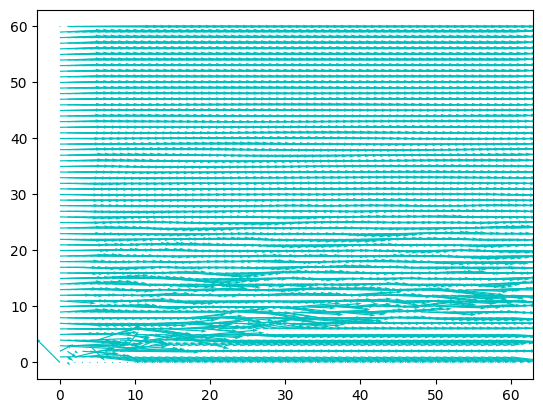

In [23]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import math

### NEW IDEA. MAKE THE SIZE OF F_OLD ONE DIMENTION LARGER ON ALL SIDES SO WE MANUALLY SLICE AND CAN ALWAYS DO THE INDEXING
### ANYTHING THAT DOES NOT MATCH WILL BE 0

# Velocity directions and weights for the lattice Boltzmann method (LBM)
Ksi = cp.array([[0, 1, 0, -1, 0, 1, -1, -1,  1],
                [0, 0, 1,  0, -1, 1,  1, -1, -1]])

w = cp.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])

c_s = 1/math.sqrt(3); # Speed of Sound
Rho_ref = 2  # Reference density
Re = 1001; # Raynold number
N_x = 60; # Number of nodes in the x-direction
N_y = 60; # Number of nodes in the x-direction
dx = 1; # Spacing in the x-direction
dy = 1; # Spacing in the y-direction
L = (N_x-1)*dx; # The domain size in x-direction

Mew = 0.1; # Kinematic viscosity
U_lid = Re*Mew/L; # Velocity of the moving lid
Tau = 3*Mew+0.5; # Relaxation Time


## Initialization
Rho = cp.ones([N_y+1,N_x+1]); # Density matrix
u = cp.ones([N_y+1,N_x+1]); # x-component velocity matrix
v = cp.ones([N_y+1,N_x+1]) # y-component velocity matrix
f_old = cp.ones([N_y + 3,N_x + 3,9]) # Old PDF matrix
f_new = cp.ones([N_y+1,N_x+1,9]) # New PDF matrix
f_eq =cp.ones([N_y+1,N_x + 1,9]) # Equilibrium PDF matrix



for t in range(10000):

  ## All interior nodes

  f_new[:, :, 0] = f_old[1:-1, 1:-1, 0];
  f_new[:, :, 1] = f_old[1:-1, :-2, 1];
  f_new[:, :, 2] = f_old[2:, 1:-1, 2];
  f_new[:, :, 3] = f_old[1:-1, 2:, 3];
  f_new[:, :, 4] = f_old[:-2, 1:-1, 4];
  f_new[:, :, 5] = f_old[2:, :-2, 5];
  f_new[:, :, 6] = f_old[2:, 2:, 6];
  f_new[:, :, 7] = f_old[:-2, 2:, 7];
  f_new[:, :, 8] = f_old[:-2, :-2, 8];

  ##Left boundary

  f_new[N_y, 0, 0] = f_old[N_y, 0, 0];
  f_new[N_y, 0, 2] = f_old[N_y + 1, 0, 2];
  f_new[N_y, 0, 3] = f_old[N_y, 1, 3];
  f_new[N_y, 0, 4] = f_old[N_y - 1, 0, 4];
  f_new[N_y, 0, 6] = f_old[N_y + 1, 1, 6];
  f_new[N_y, 0, 7] = f_old[N_y - 1, 1, 7];

  f_new[N_y, 0, 1] = f_new[N_y, 0, 3];
  f_new[N_y, 0, 5] = f_new[N_y, 0, 7] +((f_new[N_y, 0, 4] - f_new[N_y, 0, 2]) / 2);
  f_new[N_y, 0, 8] = f_new[N_y, 0, 6] + ((f_new[N_y, 0, 2] - f_new[N_y, 0, 4]) / 2);


  ## right boundary

  f_new[N_y, N_x, 0] = f_old[N_y, N_x, 0];
  f_new[N_y, N_x, 1] = f_old[N_y, N_x - 1, 1];
  f_new[N_y, N_x, 2] = f_old[N_y + 1, N_x, 2];
  f_new[N_y, N_x, 4] = f_old[N_y - 1, N_x, 4];
  f_new[N_y, N_x, 5] = f_old[N_y + 1, N_x - 1, 5];
  f_new[N_y, N_x, 8] = f_old[N_y - 1, N_x - 1, 8];

  f_new[N_y, N_x, 3] = f_new[N_y, N_x, 1];
  f_new[N_y, N_x, 6] = f_new[N_y, N_x, 8] + ((f_new[N_y, N_x, 4] - f_new[N_y, N_x, 2]))/ 2;
  f_new[N_y, N_x, 7] = f_new[N_y, N_x, 5] + ((f_new[N_y, N_x, 2] - f_new[N_y, N_x, 4])) / 2;



 ## other nodes on the top boundary

  f_new[0, :, 0] = f_old[0, 1:-1, 0];
  f_new[0, :, 1] = f_old[0, :-2, 1];
  f_new[0, :, 2] = f_old[1, 1:-1, 2];
  f_new[0, :, 3] = f_old[1, 2:, 3];
  f_new[0, :, 5] = f_old[1, :-2, 5];
  f_new[0, :, 6] = f_old[1, 2:, 6];

  f_new[0, :, 4] = f_new[0, :, 2];
  Rho_b = f_new[1, :, 0] + f_new[0, :, 1] + f_new[0, :, 3] + 2 * (f_new[0, :, 2] + f_new[0, :, 5] + f_new[0, :, 6]);
  f_new[0, :, 7] = f_new[0, :, 5] + (f_new[0, :, 1] - f_new[0, :, 3]) / 2 - Rho_b * U_lid / 2;
  f_new[0, :, 8] = f_new[0, :, 6] + (f_new[0, :, 3] - f_new[0, :, 1]) / 2 + Rho_b * U_lid / 2;

  ##All nodes on bottom boundary

  f_new[N_y, :, 0] = f_old[N_y, 1:-1, 0];
  f_new[N_y, :, 1] = f_old[N_y, :-2, 1];
  f_new[N_y, :, 3] = f_old[N_y, 2:, 3];
  f_new[N_y, :, 4] = f_old[N_y, 2:, 4];
  f_new[N_y, :, 7] = f_old[N_y - 1, 2:, 7];
  f_new[N_y, :, 8] = f_old[N_y - 1, :-2, 8];

  f_new[N_y, :, 2] = f_new[N_y, :, 4];
  f_new[N_y, :, 5] = f_new[N_y, :, 7] + (f_new[N_y, :, 3] - f_new[N_y, :, 1]) / 2;
  f_new[N_y, :, 6] = f_new[N_y, :, 8] + (f_new[N_y, :, 1] - f_new[N_y, :, 3]) / 2;


  ## Bottom boundary.
  #Bottom left corner node  n = N_y, m ==0

  f_new[N_y, 0, 0] = f_old[N_y, 0, 0];
  f_new[N_y, 0, 3] = f_old[N_y, 1, 3];
  f_new[N_y, 0, 4] = f_old[N_y - 1, 0, 4];
  f_new[N_y, 0, 7] = f_old[N_y - 1, 1, 7];

  f_new[N_y, 0, 1] = f_new[N_y, 0, 3];
  f_new[N_y, 0, 2] = f_new[N_y, 0, 4];
  f_new[N_y, 0, 5] = f_new[N_y, 0, 7];


  Rho_b = (Rho[N_y - 1, 1] + Rho[N_y, 2]) / 2;
  f_new[N_y, 1, 6] = (Rho_b - f_new[N_y, 1, 0] - f_new[N_y, 1, 1] - f_new[N_y, 1, 2] - f_new[N_y, 1, 3] - f_new[N_y, 1, 4] - f_new[N_y, 1, 5] - f_new[N_y, 1, 7]) / 2;
  f_new[N_y, 1, 8] = f_new[N_y, 1, 6];


  #Top boundary, Top Left Corner (n & m == 1)

  f_new[0, 0, 0] = f_old[0, 0, 0];
  f_new[0, 0, 2] = f_old[1, 0, 2];
  f_new[0, 0, 3] = f_old[0, 1, 3];
  f_new[0, 0, 6] = f_old[1, 1, 6];

  f_new[0, 0, 1] = f_new[0, 0, 3];
  f_new[0, 0, 4] = f_new[0, 0, 2];
  f_new[0, 0, 8] = f_new[0, 0, 6];

  Rho_b = (Rho[1, 0] + Rho[0, 1]) / 2;
  f_new[0, 0, 5] = (Rho_b - f_new[0, 0, 0] - f_new[0, 0, 1] - f_new[0, 0, 2] - f_new[0, 0, 3] - f_new[0, 0, 4] - f_new[0, 0, 6] - f_new[0, 0, 8]) / 2;
  f_new[0, 0, 7] = f_new[0, 0, 5];


  ## top right corner node N == 1 AND M == N_x

  f_new[0, N_x, 0] = f_old[0, N_x, 0];
  f_new[0, N_x, 1] = f_old[0, N_x - 1, 1];
  f_new[0, N_x, 2] = f_old[1, N_x, 2];
  f_new[0, N_x, 5] = f_old[1, N_x - 1, 5];

  f_new[0, N_x, 3] = f_new[0, N_x, 1];
  f_new[0, N_x, 4] = f_new[0, N_x, 2];
  f_new[0, N_x, 7] = f_new[0, N_x, 5];

  Rho_b = (Rho[1, N_x] + Rho[0, N_x - 1]) / 2;
  f_new[0, N_x, 6] = (Rho_b - f_new[0, N_x, 0] - f_new[0, N_x, 1] - f_new[0, N_x, 2] - f_new[0, N_x, 3] - f_new[0, N_x, 4] - f_new[0, N_x, 5] - f_new[0, N_x, 7]) / 2;
  f_new[0, N_x, 8] = f_new[0, N_x, 6]

  ##Bottom Right

  f_new[N_y, N_x, 0] = f_old[N_y, N_x, 0];
  f_new[N_y, N_x, 1] = f_old[N_y, N_x - 1, 1];
  f_new[N_y, N_x, 4] = f_old[N_y - 1, N_x, 4];
  f_new[N_y, N_x, 8] = f_old[N_y - 1, N_x - 1, 8];

  f_new[N_y, N_x, 3] = f_new[N_y, N_x, 1];
  f_new[N_y, N_x, 2] = f_new[N_y, N_x, 4];
  f_new[N_y, N_x, 6] = f_new[N_y, N_x, 8];
  Rho_b = (Rho[N_y - 1, N_x] + Rho[N_y, N_x - 1]) / 2;
  f_new[N_y, N_x, 5] = (Rho_b - f_new[N_y, N_x, 0] - f_new[N_y, N_x, 1] - f_new[N_y, N_x, 2] - f_new[N_y, N_x, 3] - f_new[N_y, N_x, 4] - f_new[N_y, N_x, 6] - f_new[N_y, N_x, 8]) / 2;
  f_new[N_y, N_x, 7] = f_new[N_y, N_x, 5];




  ##Moment calculation
  Rho = cp.sum(f_new, axis=2)
  u =(f_new[:,:,1]+f_new[:,:,5]+f_new[:,:,8]-f_new[:,:,3]-f_new[:,:,6]-f_new[:,:,7])/Rho
  v=(f_new[:,:,2]+f_new[:,:,5]+f_new[:,:,6]-f_new[:,:,4]-f_new[:,:,7]-f_new[:,:,8])/Rho


  cu_inner =  u[..., None] * Ksi[0, :] + v[..., None] * Ksi[1, :]

  # Compute the equilibrium distribution function.
  f_eq = (Rho[..., None] * w[None, None, :] *(1 + cu_inner / c_s**2 + cu_inner**2 / (2 * c_s**4) - (u**2 + v**2)[..., None] / (2 * c_s**2)))

  f_old = f_new-(f_new-f_eq)/Tau;
  f_old = cp.resize(f_old, (N_y+3,N_x+3,9))
  #f_old = cp.pad(f_new, pad_width=1, mode='constant', constant_values=0)





##plot
xReal = [0,0.0625,0.0703,0.0781,0.0938,0.1563,0.2266,0.2344,0.5,0.8047,0.8594,0.9063,0.9453,0.9531,0.9609,0.9688];
yReal = [0,0.09233,0.10091,0.1089,0.12317,0.16077,0.17507,0.17527,0.05454,-0.24533,-0.22445,-0.16914,-0.10313,-0.08864,-0.07391,-0.05906];

fig, ax = plt.subplots()

# Plot the first line
# ax.plot(xReal, yReal)

X, Y = cp.meshgrid(cp.arange(N_x+1), cp.arange(N_y+1))
# Plot the second line
ax.quiver(X.get(), Y.get(), cp.flipud(u).get(), cp.flipud(v).get(), scale=1,  color ='c')

# Add a legend
#plt.legend()

# Show the plot
plt.show()